# Imports

In [9]:
import json
import torch
from model import TextUMC, Claim, Evidence
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

# Load data

In [10]:
example_data = json.load(open("../dataset/LIAR-RAW/test.json"))[403]
example_claim = Claim(
    claim_id="403",
    content=example_data["claim"],
    label=example_data["label"],
    explanation=example_data["explain"]
)

for evidence in example_data["reports"]:
    example_claim.evidences.append(
        Evidence(evidence_id=evidence["report_id"], content=evidence["content"])
    )

print(f"Claim: {example_claim.content}")
print(f"Number of evidences: {len(example_claim.evidences)}")


Claim: Im not a conspiracy theorist and I never allow conspiracy theorists on my program.
Number of evidences: 28


# Initialize model and get embeddings

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextUMC().to(device)

with torch.no_grad():
    evidence_texts = [ev.content for ev in example_claim.evidences]
    evidence_embeddings = model(evidence_texts)
    evidence_embeddings_np = evidence_embeddings.cpu().numpy()

print(f"Evidence embeddings shape: {evidence_embeddings_np.shape}")

Output()

Evidence embeddings shape: (28, 128)


In [15]:
evidence_embeddings_np

array([[0.01634, 0.     , 0.     , ..., 0.1589 , 0.366  , 0.     ],
       [0.11584, 0.     , 0.     , ..., 0.0443 , 0.4136 , 0.     ],
       [0.0551 , 0.     , 0.     , ..., 0.2294 , 0.3325 , 0.     ],
       ...,
       [0.3467 , 0.04242, 0.     , ..., 0.     , 0.3215 , 0.     ],
       [0.0926 , 0.     , 0.     , ..., 0.01279, 0.4468 , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.1501 , 0.34   , 0.     ]],
      shape=(28, 128), dtype=float16)

# Visualize embeddings with PCA

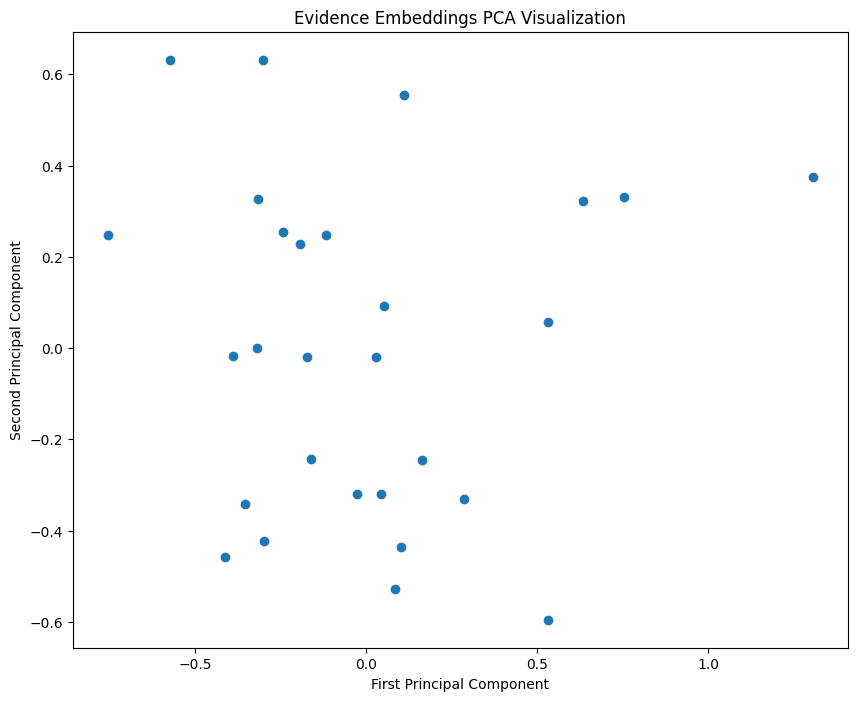

In [12]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(evidence_embeddings_np)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title("Evidence Embeddings PCA Visualization")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

# Load and inspect training results

In [ ]:
results_path = "../outputs/latest/results.json"  # Update with your results path
with open(results_path, 'r') as f:
    results = json.load(f)

# Print training metrics
print("Training Metrics:")
print(json.dumps(results['metrics'], indent=2))


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 results_path = "../outputs/20250110_115253/evidence_clusters.png"  # Update with your re     │
│ ❱ 2 with open(results_path, 'r') as f:                                                           │
│   3 │   results = json.load(f)                                                                   │
│   4                                                                                              │
│   5 # Print training metrics                                                                     │
│                                                                                                  │
│ /home/lonk/micromamba/envs/thesis/lib/python3.12/site-packages/IPython/core/interactiveshell.py: │
│ 324 in _modified_open                                                                            │
│                                                                                                  │
│    321 │   │   │   "you can use builtins' open."                                                 │
│    322 │   │   )                                                                                 │
│    323 │                                                                                         │
│ ❱  324 │   return io_open(file, *args, **kwargs)                                                 │
│    325                                                                                           │
│    326 class InteractiveShell(SingletonConfigurable):                                            │
│    327 │   """An enhanced, interactive shell for Python."""                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: '../outputs/20250110_115253/evidence_clusters.png'

# Visualize clustered evidences

In [7]:
claim = results['claims'][0]
clusters = claim['clustered_evidences']

print("\nEvidence Clusters:")
for cluster_id, evidences in clusters.items():
    print(f"\nCluster {cluster_id}:")
    for ev in evidences[:2]:  # Show first 2 evidences per cluster
        print(f"- {ev['content'][:100]}...")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 claim = results['claims'][0]                                                                 │
│   2 clusters = claim['clustered_evidences']                                                      │
│   3                                                                                              │
│   4 print("\nEvidence Clusters:")                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'results' is not defined

# Plot training loss

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results['metrics']['epoch_losses'])
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()